In [101]:
import skimage.io as io
import skimage.transform as trans
import matplotlib.pyplot as plt
import cv2
from glob import glob
from PIL import Image as im
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import *
from keras.models import *
from keras.callbacks import *
from keras.optimizers.optimizer_v2.adam import Adam
from skimage import img_as_uint
from sklearn.metrics import accuracy_score, precision_score, recall_score
from keras.metrics import Recall, Precision, Accuracy

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [102]:
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def unet(input_shape = (512, 512, 3)):
    inputs = Input(input_shape)
    channels = 64
    s1, p1 = encoder_block(inputs, channels)
    s2, p2 = encoder_block(p1, channels*2)
    s3, p3 = encoder_block(p2, channels*4)
    s4, p4 = encoder_block(p3, channels*8)

    b1 = conv_block(p4, channels*16)

    d1 = decoder_block(b1, s4, channels*8)
    d2 = decoder_block(d1, s3, channels*4)
    d3 = decoder_block(d2, s2, channels*2)
    d4 = decoder_block(d3, s1, channels)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate = 1e-4), loss = 'binary_crossentropy', metrics = [Recall(), Precision()])
    return model

In [103]:
def adjustData(img,mask, img_v, mask_v):
    img = img / 255.
    img = img.astype(np.float32)
    img_v = img_v / 255.
    img_v = img_v.astype(np.float32)
    mask = mask /255.
    mask = mask.astype(np.float32)
    mask_v = mask_v /255.
    mask_v = mask_v.astype(np.float32)

    return img,mask, img_v, mask_v

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = trans.resize(x,(512,512))
    x = x/255.0
    x = x.astype(np.int32)
    return x

def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = trans.resize(x,(512,512))
    x = x/255.0
    x = x.astype(np.float32)
    return x

def testGenerator(train_path, target_size=(512,512)):
    for i in range(1, 19):
        if i<10:
            img = io.imread(os.path.join(train_path,"0%d_h.jpg"%i))
        else:
            img = io.imread(os.path.join(train_path,"%d_h.jpg"%i))
        img = trans.resize(img,target_size)
        img = np.reshape(img,(1,)+img.shape)
        yield img

def trainGenerator(batch_size,train_path,image_folder,mask_folder,aug_dict,image_color_mode = "grayscale",
                    mask_color_mode = "grayscale",image_save_prefix  = "image",mask_save_prefix  = "mask",
                    flag_multi_class = False,num_class = 2,save_to_dir = None,target_size = (512,512),seed = 1):
    '''
    can generate image and mask at the same time
    use the same seed for image_datagen and mask_datagen to ensure the transformation for image and mask is the same
    if you want to visualize the results of generator, set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        subset='training',
        seed=seed)
    image_valid = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        subset='validation',
        seed=seed)
    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = 'grayscale',
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        subset='training',
        seed=seed
    )
    mask_valid = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = 'grayscale',
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        subset='validation',
        seed=seed
    )
    train_generator = zip(image_generator, mask_generator, image_valid, mask_valid)
    for (img,mask, img_v, mask_v) in train_generator:
        img,mask, img_v, mask_v = adjustData(img,mask, img_v, mask_v)
        yield img,mask, img_v, mask_v

def print_result():
    train_x = sorted(glob(os.path.join("./", "eye", "*.jpg")))
    train_y = sorted(glob(os.path.join("./", "mask", "*.tif")))
    pred_mask = sorted(glob(os.path.join("./", "results", "*.png")))
    for i in range(len(train_x)):
        f, axarr = plt.subplots(nrows=1, ncols=3, figsize=(12,5), squeeze=False)
        x = cv2.imread(train_x[i])
        x = cv2.cvtColor(x, cv2.COLOR_RGB2BGR)
        axarr[0,0].imshow(x)
        axarr[0,1].imshow(cv2.imread(train_y[i], cv2.IMREAD_COLOR))
        axarr[0,2].imshow(cv2.imread(pred_mask[i], cv2.IMREAD_COLOR))
        plt.show()


def saveResult(save_path, npyfile):
    for i,item in enumerate(npyfile):
        item[item > 0.3] = 1.0
        item[item<= 0.3] = 0.0
        io.imsave(os.path.join(save_path,f"{i+1}_predict.png"),img_as_uint(item))

In [104]:
def train_model():
    data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    validation_split = 0.3,
                    fill_mode='nearest')
    batch_size = 4
    myGene = trainGenerator(4,'./','eye','mask',data_gen_args,save_to_dir = None)
    model_checkpoint = ModelCheckpoint('unet_eye4.hdf5', verbose=1, monitor='loss', save_best_only=True)
    es = EarlyStopping(monitor='val_loss', mode='min', patience=15, restore_best_weights=True)
    model = unet()
    model.load_weights('unet_eye4.hdf5')
    x, y, x_v, y_v = next(myGene)
    history = model.fit(x, y, steps_per_epoch=7, epochs=200, validation_data=(x_v, y_v), callbacks=[model_checkpoint, es])
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.legend()
    plt.savefig(f"./plots/{batch_size}.png")


def test_model():
    model = unet()
    model.load_weights('unet_eye4.hdf5')
    testGene = testGenerator("eye")
    results = model.predict(testGene, steps=18,verbose=1)
    saveResult("results",results)
    train_y = sorted(glob(os.path.join("./", "mask", "*.tif")))
    SCORE = []
    for i,item in enumerate(results):
        item = item > 0.3
        item = item.astype(np.int32)
        item = np.squeeze(item, axis=-1)
        y = read_mask(train_y[i]).flatten()
        item = item.flatten()
        acc_value = accuracy_score(y, item)
        recall_value = recall_score(y, item, labels=[0, 1], average="binary", zero_division=1)
        precision_value = precision_score(y, item, labels=[0, 1], average="binary", zero_division=1)
        SCORE.append([acc_value, recall_value, precision_value])
    score = np.mean(SCORE, axis=0)
    print(f"\nAccuracy: {score[0]}")
    print(f"Recall: {score[1]}")
    print(f"Precision: {score[2]}")




18/18 [==============================] - 38s 2s/step

Accuracy: 0.9211807250976562
Recall: 1.0
Precision: 0.0


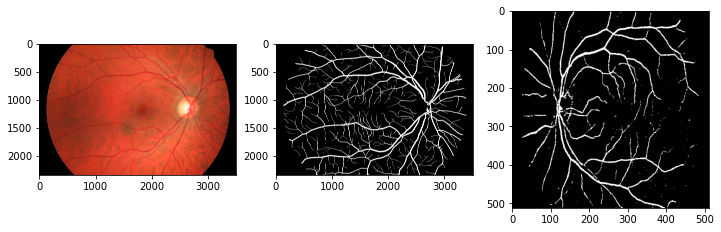

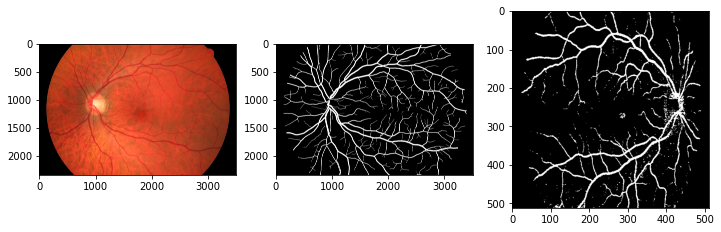

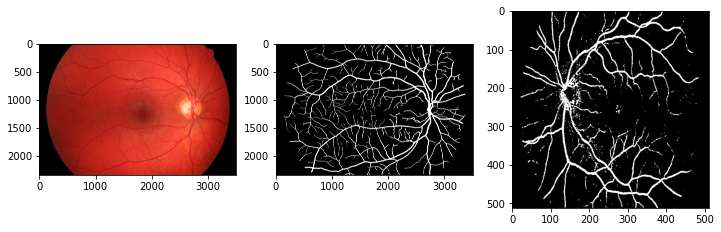

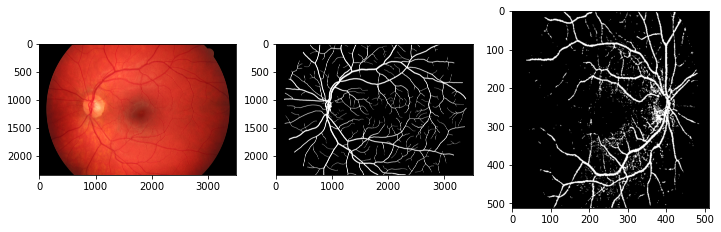

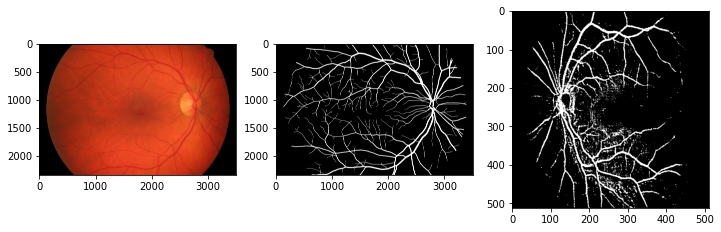

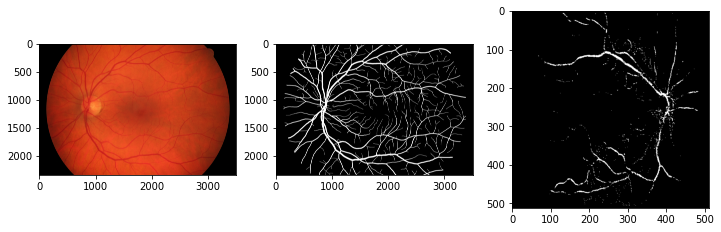

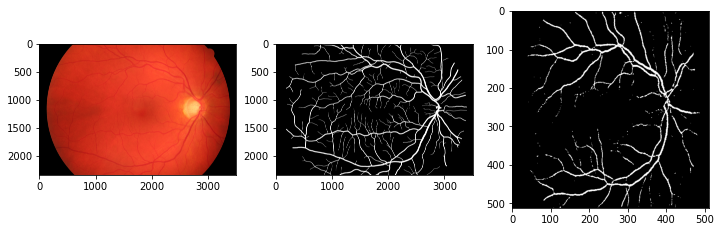

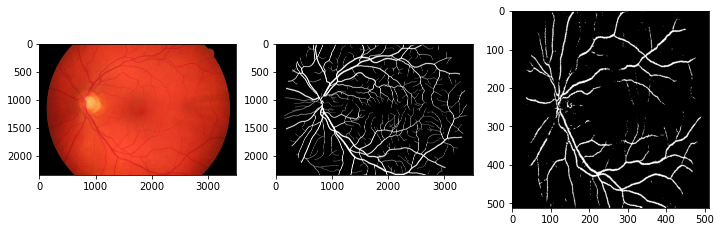

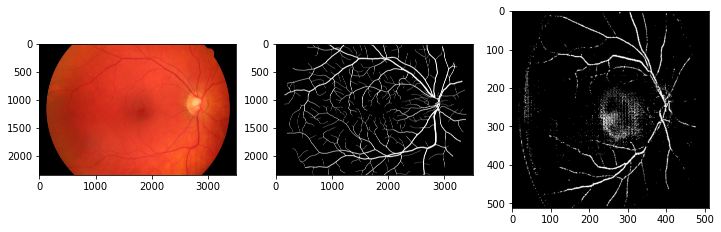

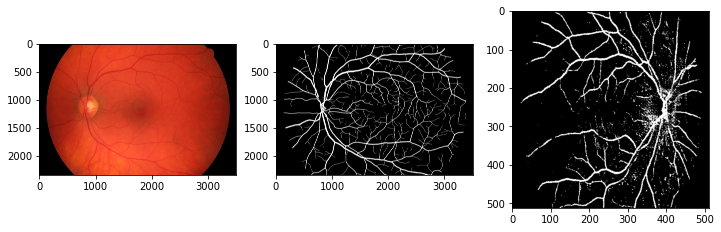

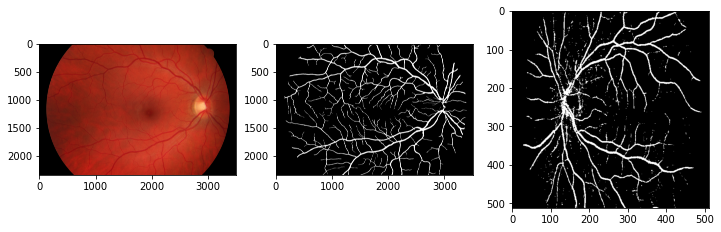

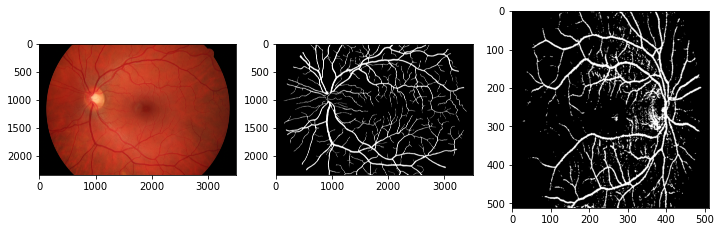

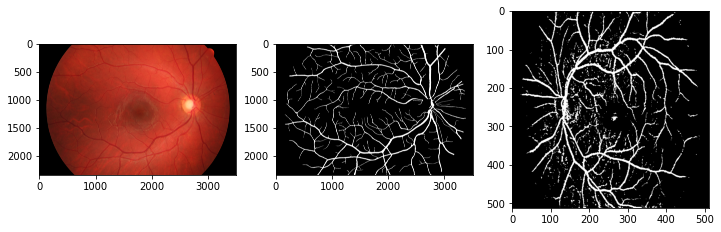

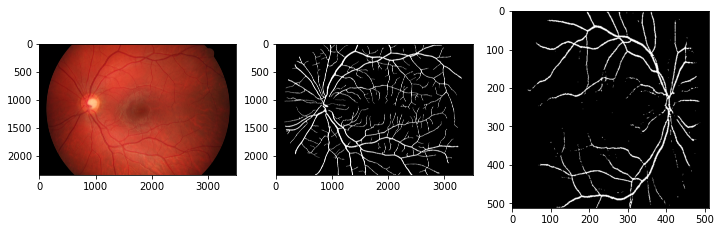

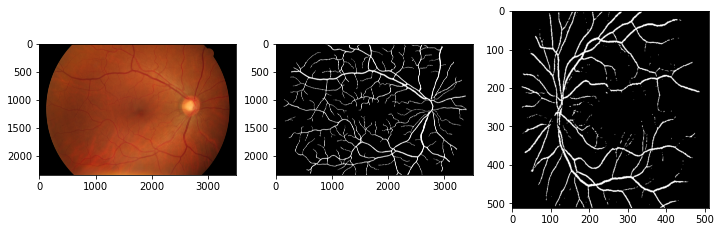

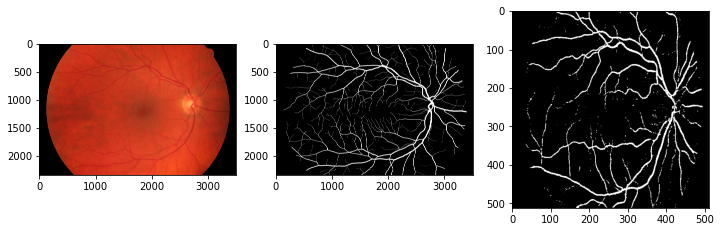

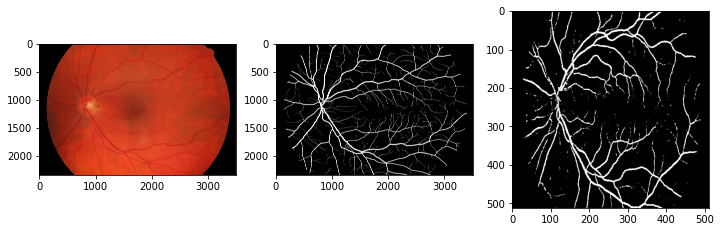

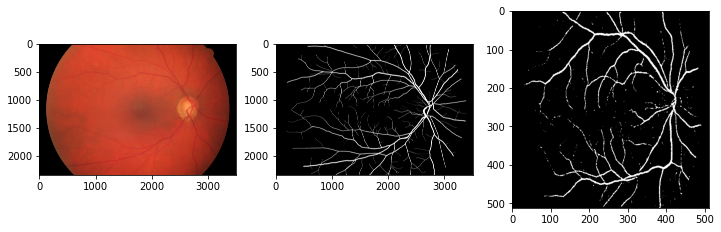

In [105]:
#train_model()
test_model()
print_result()